# Answering Business Questions using SQL

In this project, we will try to answer certain business questions using SQL. For each task we will:
- Write a SQL query to extract the relevant data
- Create plots whenever necessary
- Explaining the results

We'll working with the famous _Chinook_ database which is provided as a SQLite database file called `chinook.db`. It is publicly available [here](https://github.com/lerocha/chinook-database). The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store. It will be very useful to have a schema diagram for the database file like below:
![image](schema.png)
[Source](https://www.dataquest.io/)
: Dataquest

## Creating Helper Functions

We can use the `sqlite3.connect()` function from [sqlite3](https://docs.python.org/3/library/sqlite3.html) module of python to create a connection object, and pass that to the `pandas.read_sql_query()` function.

In [1]:
# importing the required libraries
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# function to return a pandas dataframe from a query
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql_query(q, conn)

# function to run sqlite command
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None             # tells sqlite to autocommit any changes
        conn.execute(c)

# function to return a list of all tables and views in database
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Selecting Albums to Purchase

Imagine that the Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce. 

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [3]:
# finding the most popular genre in the USA
albums_to_purchase = '''
                    WITH usa_tracks_sold AS
                    (
                     SELECT 
                         il.*
                         FROM invoice_line il
                         INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                         INNER JOIN customer c ON c.customer_id = i.customer_id
                         WHERE c.country = "USA"
                    )
                    SELECT 
                        g.name genre,
                        COUNT(uts.invoice_line_id) tracks_sold,
                        (CAST(COUNT(uts.invoice_line_id) AS FLOAT) / (
                            SELECT COUNT(*) FROM usa_tracks_sold))*100 percentage_sold
                    FROM usa_tracks_sold uts
                    INNER JOIN track t ON t.track_id = uts.track_id
                    INNER JOIN genre g ON g.genre_id = t.genre_id
                    GROUP BY 1
                    ORDER BY 2 DESC
                    LIMIT 10;
                    '''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


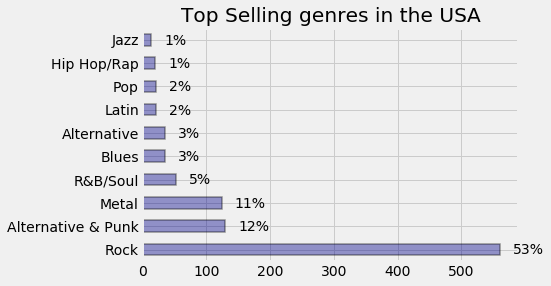

In [4]:
# generating plot of the genres
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", drop=True, inplace=True)
 
plt.style.use('fivethirtyeight')
genre_sales_usa['tracks_sold'].plot.barh(title = 'Top Selling genres in the USA',
                                         legend=False, color='darkblue', alpha=0.4, 
                                         edgecolor='black', linewidth=1.5, fontsize=14)

for i, label in enumerate(genre_sales_usa.index): # put percentages as annotations on each bar
    x = genre_sales_usa.loc[label,'tracks_sold']
    y = genre_sales_usa.loc[label,'percentage_sold'].astype(int).astype(str) + "%"
    plt.text(x+20, i-0.2, str(y))
    
plt.ylabel('')
plt.show()

Rock is the most popular genre in USA with a share of 53% of the total albums sold followed by Alternative & Punk and Metal. However, the corresponding percentages of these two genres are much less than that of Rock.

Our goal is to select three albums out of the following four based on the genres which sell the best in the USA:

| __Artist Name__ | __Genre__ |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Meteor and the Girls | Pop |
| Slim Jim Bites | Blues |

From the bar plot above, we should definitely select Red Tone since Alternative & Punk is relatively high selling genre. But the genres- Pop, Blues, and Hip-Hop, all have almost the same percentage so it is kind of difficult to select two out of these three but on the basis of their relative percentages, we should select Blues and Pop. 

## Analyzing Employee Sales Performance

In [5]:
# finding the sales breakdown by employees
best_performing_employee = '''
    WITH employee_performance AS
    (
     SELECT
         e.first_name || " " || e.last_name employee_name,
         e.employee_id,
         e.hire_date,
         c.customer_id,
         i.total
     FROM customer c
     INNER JOIN employee e ON e.employee_id = c.support_rep_id
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     WHERE e.title = 'Sales Support Agent'
    )
    SELECT 
        ep.employee_name,
        SUM(ep.total) total_sales,
        (CAST(SUM(ep.total) AS FLOAT) / 
        (SELECT SUM(total) FROM employee_performance))*100 percent_sales,
        ep.hire_date
    FROM employee_performance ep
    GROUP BY ep.employee_id
    ORDER BY 2 DESC;
'''
run_query(best_performing_employee)

,employee_name,total_sales,percent_sales,hire_date
0,Jane Peacock,1731.51,36.766870,2017-04-01 00:00:00
1,Margaret Park,1584.00,33.634644,2017-05-03 00:00:00
2,Steve Johnson,1393.92,29.598486,2017-10-17 00:00:00


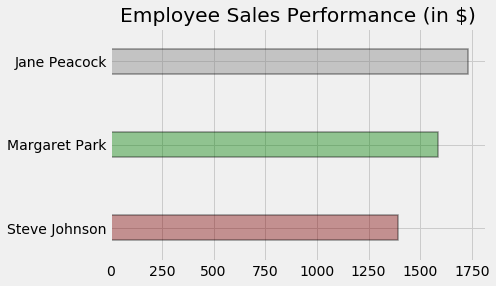

In [6]:
# plotting the results
best_sales_rep = run_query(best_performing_employee)
best_sales_rep.set_index("employee_name", drop=True, inplace=True)
best_sales_rep.sort_values('total_sales', inplace=True)
best_sales_rep['total_sales'].plot.barh(title='Employee Sales Performance (in $)',
                                        legend=False, color=['maroon', 'green', 'gray'], 
                                        alpha=0.4, width =.3, 
                                         edgecolor='black', linewidth=1.5, fontsize=14)
plt.ylabel('')
plt.show()

The difference in sales by the top employee(Jane Peacock) and the bottom employee (Steve Johnson) is accounted by their different hiring dates.

## Analyzing Sales by Country

In [7]:
sales_by_country = '''
    WITH sales_by_country AS
    (
     SELECT
       CASE
         WHEN(
              SELECT COUNT(customer_id)
              FROM customer
              where country = c.country
              ) = 1 THEN "Other"
           ELSE c.country
         END AS country,
         c.customer_id,
         il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )
    SELECT
         country,
         customers,
         total_sales,
         avg_sales,
         avg_order
    FROM
    (
    SELECT 
        country,
        COUNT(DISTINCT(customer_id)) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT(customer_id)) avg_sales,
        SUM(unit_price) / COUNT(DISTINCT(invoice_id)) avg_order,
        CASE
          WHEN country = "Other" THEN 1
          ELSE 0
        END AS sort
    FROM sales_by_country
    GROUP BY country
    ORDER BY sort ASC, 2 DESC
    );
'''
run_query(sales_by_country)

,country,customers,total_sales,avg_sales,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.448571


## Visualizing Sales by Country

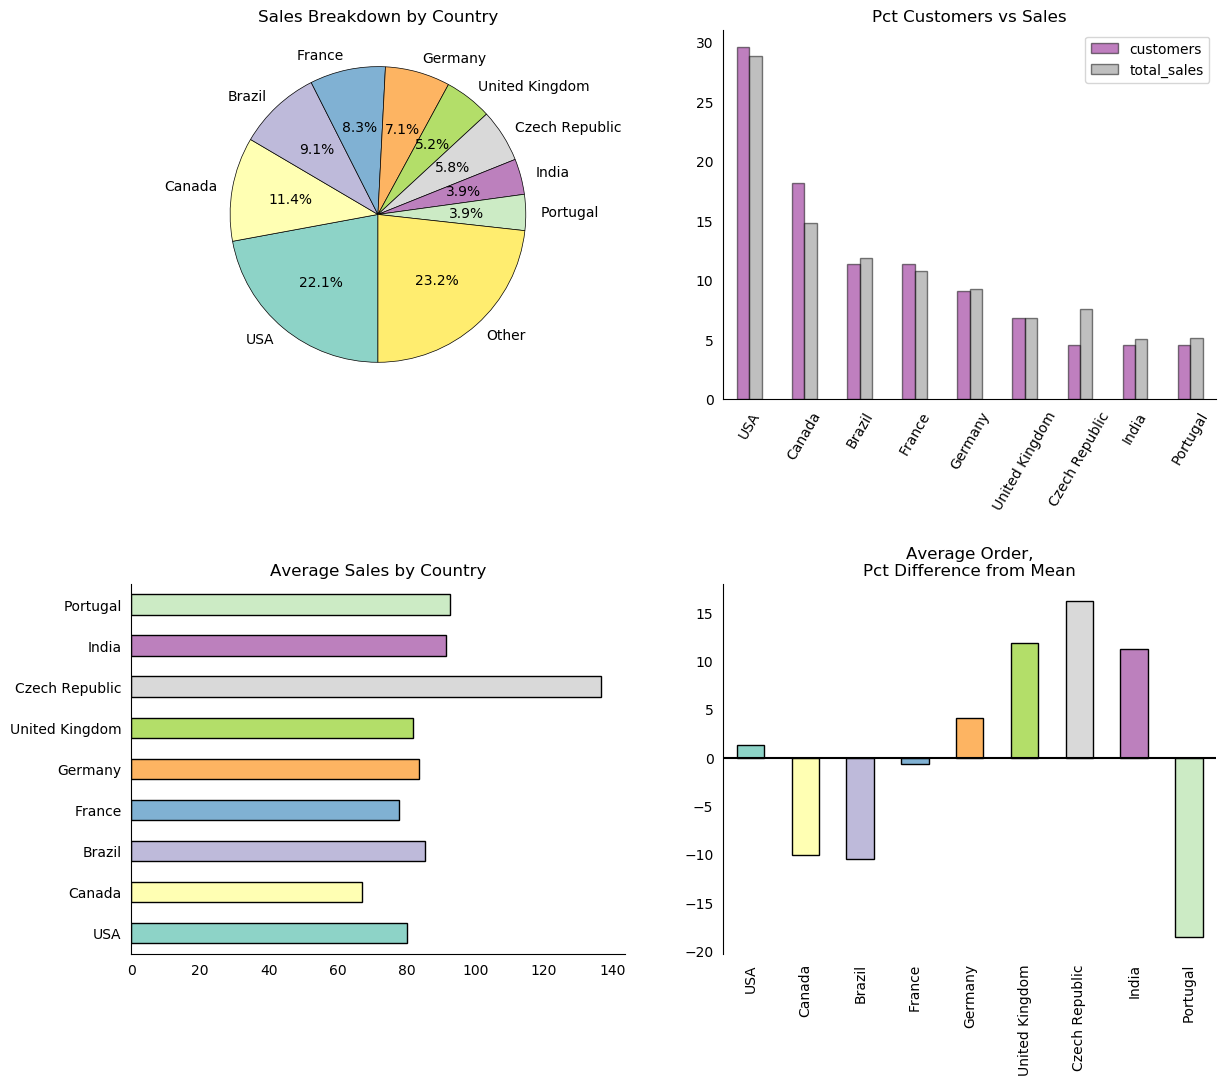

In [8]:
import numpy as np
plt.style.use('default')
by_country = run_query(sales_by_country)
by_country.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Set3(i) for i in np.linspace(0, 1, by_country.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
ax1, ax2, ax3, ax4 = axes.flatten()                  # give coordinates of four axes objects
fig.subplots_adjust(hspace=.5, wspace=.2)            # add horizontal and vertical space buffer

# top left
sales_breakdown = by_country["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    title='Sales Breakdown by Country',
    counterclock=False,
    colormap=plt.cm.Set3, 
    fontsize=10,
    autopct='%1.1f%%',
    wedgeprops={'linewidth':0.5, 'edgecolor':'black'})

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = by_country[cvd_cols].copy()
custs_vs_dollars.index.name = ''                              # removes the y-label
custs_vs_dollars.drop('Other', inplace=True)
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100    # normalize the columns to same scale
custs_vs_dollars.plot.bar(
    ax=ax2,
    color=['purple','gray'],
    alpha=0.5,
    rot=60,
    title="Pct Customers vs Sales",
    width=0.45,
    edgecolor='black', linewidth=1.0
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
average_sales = by_country['avg_sales'].copy()
average_sales.index.name = ''
average_sales.drop("Other", inplace=True)                    # remove the "Other" column from plots
average_sales.plot.barh(
    ax=ax3,
    color=colors,
    title='Average Sales by Country',
    edgecolor='black', linewidth=1.0
)
ax3.tick_params(top=False, right=False, left=False, bottom=False)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# bottom right
avg_order = by_country["avg_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100  # percent difference from the mean
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax4,
    color=colors,
    title="Average Order,\nPct Difference from Mean",
    edgecolor='black', linewidth=1.0
)
ax4.tick_params(top=False, right=False, left=False, bottom=False)
ax4.axhline(0, color='k', linewidth=1.5)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
ax4.spines["bottom"].set_visible(False)
plt.show()

Based on the data, we see that the countries that have potential for growth are:
- Czech Republic
- United Kingdom 
- India

Although the lower right plot suggest that these three countries could be the good market for advertising campaign, we should be really cautious and only make small investments in ad campaigns because the percent customers and percent sales breakdown show a small percentage for these countries.

Also, since the `Other` is not representative of any single country so it is not relevant to out analysis and we droppped it.

## Albums vs Individual Tracks

In [9]:
album_purchases = """ 
WITH 
    invoice_details AS 
    (
    SELECT 
        il.invoice_id, 
        il.track_id, 
        a.album_id 
    FROM invoice_line il 
    INNER JOIN track t ON t.track_id = il.track_id 
    INNER JOIN album a ON a.album_id = t.album_id 
    GROUP BY il.invoice_id 
    ), 
    
    full_album AS 
    (
    SELECT
        a.album_id, 
        t.track_id 
    FROM album a 
    INNER JOIN track t on a.album_id = t.album_id 
    ), 
    
    album_table AS 
    (
    SELECT inv.invoice_id, 
      CASE 
        WHEN 
        ( 
         SELECT f.track_id album_track
         FROM full_album f
         WHERE inv.album_id = f.album_id 
         EXCEPT 
         SELECT il.track_id 
         FROM invoice_line il
         WHERE il.invoice_id = inv.invoice_id
        ) IS NULL
    and
        (
         SELECT il.track_id 
         FROM invoice_line il
         WHERE il.invoice_id = inv.invoice_id 
         EXCEPT 
         SELECT f.track_id album_track
         FROM full_album f
         WHERE inv.album_id = f.album_id
        ) IS NULL 
    THEN 'Yes' 
    ELSE 'No' 
    END AS album_purchase 
    FROM invoice_details inv
    GROUP BY inv.invoice_id
    )
SELECT 
album_purchase,
COUNT(invoice_id) number_of_invoices,
CAST(count(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percent
FROM album_table
GROUP BY album_purchase
"""
run_query(album_purchases)

,album_purchase,number_of_invoices,percent
0,No,500,0.814332
1,Yes,114,0.185668


From the table above, we see about 81% of the total purchases are not album purchases. So we recommend not to buy full albums from record companies in order to avoid losses.